<a href="https://colab.research.google.com/github/mrpintime/TitanicSurvivor/blob/main/Titanic_(Kaggle_Competition).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic Survivors

Created by Moein aka Mrpintime


these two cells are for download data from kaggle

In [ ]:
# import opendatasets as op

In [ ]:
# op.download("https://www.kaggle.com/c/titanic")

# Dataset Description

Variable  |	Definition   |	Key   |
----------| -----------  | -------|
survival  |	Survival     |	0 = No, 1 = Yes
pclass 	  | Ticket class 	   |1 = 1st, 2 = 2nd, 3 = 3rd
sex 	    | Sex
Age 	    | Age in years
sibsp 	  | # of siblings / spouses aboard the Titanic
parch 	  | # of parents / children aboard the Titanic
ticket 	  | Ticket number
fare 	    | Passenger fare
cabin 	  | Cabin number
embarked 	| Port of Embarkation |	C = Cherbourg, Q = Queenstown, S = Southampton

## **Variable Notes**

**pclass**: A proxy for socio-economic status (SES)
**1st** = Upper
**2nd** = Middle
**3rd** = Lower

`age`: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

`sibsp`: The dataset defines family relations in this way...
**Sibling** = brother, sister, stepbrother, stepsister
**Spouse** = husband, wife (mistresses and fiancés were ignored)

`parch`: The dataset defines family relations in this way...
**Parent** = mother, father
**Child** = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore `parch=0` for them.


# Problem
The sinking of the Titanic is one of the most famous happend in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren't enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we want to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

# Import Dataset

**important note** : we have two dataset for this copetition that created by kaggle, so first we do preprocessing on train set and then we use test set for evaluation our models.

In [1]:
import pandas as pd, numpy as np, seaborn as sns
import matplotlib.pyplot as plt


In [82]:
df = pd.read_csv('/content/drive/MyDrive/Titanic/train.csv')

In [83]:
# df.to_csv("/content/drive/MyDrive/Titanic/train.csv", index=False)

# Exploratory data analysis

## Cleansing

**Let's see dataset shape, columns, missing values**

it is normal dataset size

In [84]:
df.shape

(891, 12)

In [85]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We have `177 missing values` for `Age` and `687 missing values` for `Cabin` and `2 missing values` for `Embarked`

In [86]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Let's see do we have `unique passangers` or `not (duplicate)`, if we have duplicate row we should `remove` it.

as we can see we do not have duplicate passengers. good for us.

In [87]:
df.duplicated().sum()

0

In [88]:
df.duplicated(['PassengerId']).sum()

0

We can remove the `Name` column cause we do not need it in our future analysis.
`If you say why we do not need it, i can tell you that can you predict somthing based on the name of the person is that reasonable ?`
but before we remove it lets do some trick and extract useful information.

In [89]:
df['Title'] = df['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]

stat_min = 10
title_names = (df['Title'].value_counts() < stat_min) #
df['Title'] = df['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)
print(df['Title'].value_counts())

Mr        517
Miss      182
Mrs       125
Master     40
Misc       27
Name: Title, dtype: int64


Now Drop the name column.

In [90]:
df = df.drop(columns=['Name'], axis=1)

In [91]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,male,35.0,0,0,373450,8.0500,NaN,S,Mr


Let's check are we can remove `Ticket` column or not

In [92]:
df.Ticket.value_counts()

347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64

As you can see we have `681 unique tickets` and `134` of them purchased more that once.

In [93]:
np.sum(df.Ticket.value_counts() > 1)

134

In [94]:
len(df.Ticket.unique())

681

So if we decide to keep it we have to convert all `681` unique tickets to numeric value and therefore if we use `get_dummies` we will have `681` extra columns with `binary` value, if we use we use `LabelEncoder` for not binary encoder we will have `681 unique values` in `one column`.
and also there are some extra information and services that provided for passengers with their tickets that did not include in dataset.


---


**In conclusion** we keep it for now

Let's deal with `nan` values in `Age`, `Embarked` and `Cabin` columns.

In [95]:
df[df.Embarked.isnull()]

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
61,62,1,1,female,38.0,0,0,113572,80.0,B28,NaN,Miss
829,830,1,1,female,62.0,0,0,113572,80.0,B28,NaN,Mrs


one approache to dealing with `nan` values is replace it with somthing reasonable. so we can use most ferquent value in `Embarked` and replace it with `NAN` value.

In [96]:
df.Embarked.describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

As we can see `S` has more frequent for fare bellow than `120`,  also more in overall, and also because we have only two nan value for `Embarked` we can set them to `S`.

In [97]:
df[df['Fare'] == 80]

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
61,62,1,1,female,38.0,0,0,113572,80.0,B28,NaN,Miss
829,830,1,1,female,62.0,0,0,113572,80.0,B28,NaN,Mrs


we can see they are only two passengers that paied 80 and also reside in Cabin B28, but as you know we have so many nan values in cabin column.

In [98]:
df[df['Cabin'] == 'B28']

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
61,62,1,1,female,38.0,0,0,113572,80.0,B28,NaN,Miss
829,830,1,1,female,62.0,0,0,113572,80.0,B28,NaN,Mrs


<Axes: xlabel='Embarked', ylabel='Fare'>

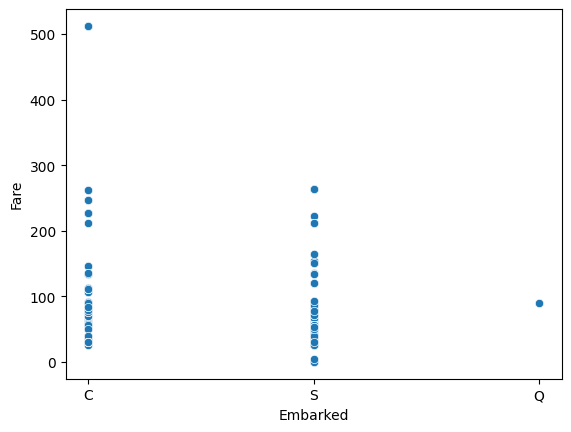

In [99]:
sns.scatterplot(df[df['Pclass'] == 1], x='Embarked', y='Fare')

In [100]:
df[df.Embarked.isnull()]

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
61,62,1,1,female,38.0,0,0,113572,80.0,B28,NaN,Miss
829,830,1,1,female,62.0,0,0,113572,80.0,B28,NaN,Mrs


We replace `NaN` values with mode of `Embarked` column.

In [101]:
df.Embarked.mode()

0    S
Name: Embarked, dtype: object

In [102]:
df.loc[[61,829],['Embarked']] = np.array(['S', 'S'])

In [103]:
df.loc[[61,829],['Embarked']]

,Embarked
61,S
829,S


In [104]:
df.Embarked.isnull().sum()

0

Let's check `Cabin` column.

In [105]:
df.Cabin.isnull().sum()

687

In [106]:
df[df.Cabin.isnull()]

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
4,5,0,3,male,35.0,0,0,373450,8.0500,NaN,S,Mr
5,6,0,3,male,NaN,0,0,330877,8.4583,NaN,Q,Mr
7,8,0,3,male,2.0,3,1,349909,21.0750,NaN,S,Master
...,...,...,...,...,...,...,...,...,...,...,...,...
884,885,0,3,male,25.0,0,0,SOTON/OQ 392076,7.0500,NaN,S,Mr
885,886,0,3,female,39.0,0,5,382652,29.1250,NaN,Q,Mrs
886,887,0,2,male,27.0,0,0,211536,13.0000,NaN,S,Misc
888,889,0,3,female,NaN,1,2,W./C. 6607,23.4500,NaN,S,Miss


In [107]:
df.Cabin.describe()

count         204
unique        147
top       B96 B98
freq            4
Name: Cabin, dtype: object

In [108]:
df.Cabin.isnull().sum() / df.shape[0]

0.7710437710437711

as you can see we have so many column with class 1

[]

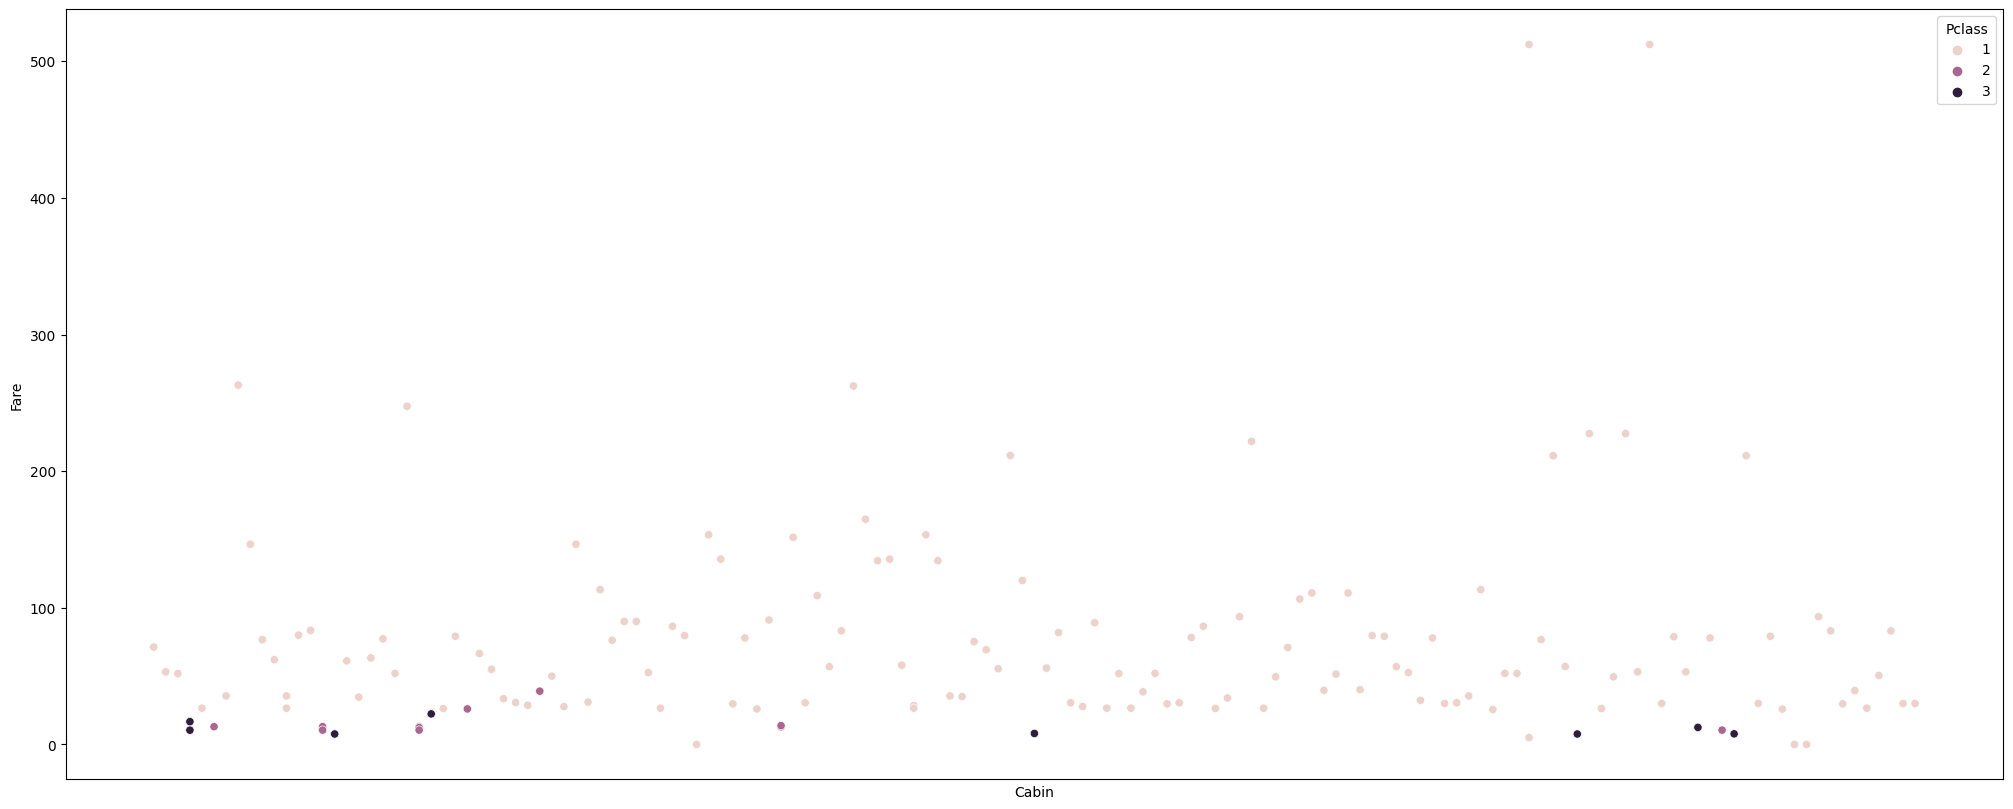

In [109]:
plt.figure(figsize=(25,10))
sns.scatterplot(df, x='Cabin', y='Fare', hue='Pclass')
frame1 = plt.gca()
frame1.axes.get_xaxis().set_ticks([])

We know cabin and class of ticket has a relation with together, in further lines we want to replace `NaN` values of `Cabin` with random values that we that we create from cabins of each classes.

In [110]:
df[df.Cabin.isnull()]['Pclass'].value_counts()

3    479
2    168
1     40
Name: Pclass, dtype: int64

In [111]:
df[~(df.Cabin.isnull())]['Pclass'].value_counts()

1    176
2     16
3     12
Name: Pclass, dtype: int64

In [112]:
cabins_class_3 = np.unique(df[(df['Pclass']==3) & ~(df.Cabin.isnull())].loc[:,'Cabin'])
cabins_class_2 = np.unique(df[(df['Pclass']==2) & ~(df.Cabin.isnull())].loc[:,'Cabin'])
cabins_class_1 = np.unique(df[(df['Pclass']==1) & ~(df.Cabin.isnull())].loc[:,'Cabin'])


In [113]:
# for cabins class 3 we have 479 null value
cabins_3 = np.random.choice(cabins_class_3, 479, replace=True)
# for cabins class 2 we have 168 null value
cabins_2 = np.random.choice(cabins_class_2, 168, replace=True)
# for cabins class 1 we have 40 null value
cabins_1 = np.random.choice(cabins_class_1, 40, replace=True)


In [114]:
nulls_cb = df.Cabin.isnull()

In [115]:
idx_c3 = df[(df['Pclass']==3) & (nulls_cb)].index
idx_c2 = df[(df['Pclass']==2) & (nulls_cb)].index
idx_c1 = df[(df['Pclass']==1) & (nulls_cb)].index


In [116]:
df.loc[idx_c3,'Cabin'] = cabins_3
df.loc[idx_c2, 'Cabin'] = cabins_2
df.loc[idx_c1, 'Cabin'] = cabins_1

In [117]:
df.Cabin.isnull().sum()

0

So as you can see it is not so easy if we want to replace `687` nan values with reasonable values also it is not good if we want to replace these numbers of data with nan values cause it makes our dataset to has bias as we see `77 percent` of all data in Cabin column are missing value so we use can do two thing:

1.   remove rows that contain `nan` value for `Cabin` column.
2.   remove `Cabin` column from our dataset
3.   find a pattern and replace `nan` values

---
we choose thid option fortunately because of distribution of cabin feature and relation with cabin class (`Pclass`) and also we will choose second one if Cabin feature will not be usefull in further analysis and we do second option because we do not want to lose so much information from other columns.

In [118]:
# df = df.drop(columns=['Cabin'], axis=1)

In [119]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,F G73,S,Mr
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,F38,S,Miss
3,4,1,1,female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,male,35.0,0,0,373450,8.0500,F G73,S,Mr


Let's Check `Age` column.

In [120]:
df.Age.isnull().sum()

177

In [121]:
df[df.Age.isnull()].head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
5,6,0,3,male,NaN,0,0,330877,8.4583,F G63,Q,Mr
17,18,1,2,male,NaN,0,0,244373,13.0000,E77,S,Mr
19,20,1,3,female,NaN,0,0,2649,7.2250,F G63,C,Mrs
26,27,0,3,male,NaN,0,0,2631,7.2250,F G63,C,Mr
28,29,1,3,female,NaN,0,0,330959,7.8792,G6,Q,Miss


In [122]:
df[df.Age.isnull()].describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,177.000000,177.000000,177.000000,0.0,177.000000,177.000000,177.000000
mean,435.581921,0.293785,2.598870,NaN,0.564972,0.180791,22.158567
std,250.552901,0.456787,0.763216,NaN,1.626316,0.534145,31.874608
min,6.000000,0.000000,1.000000,NaN,0.000000,0.000000,0.000000
25%,230.000000,0.000000,3.000000,NaN,0.000000,0.000000,7.750000
50%,452.000000,0.000000,3.000000,NaN,0.000000,0.000000,8.050000
75%,634.000000,1.000000,3.000000,NaN,0.000000,0.000000,24.150000
max,889.000000,1.000000,3.000000,NaN,8.000000,2.000000,227.525000


In [123]:
df['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

There are two way:

1. we pick random numbers from dense area of age distribution.
2. replace `NaN` values with `mean` or `median` of age feature.
**Note**: we can use `clustering` to find a value to replace with `nan` values but we do it in another version of this notebook.

<Axes: xlabel='Age', ylabel='Density'>

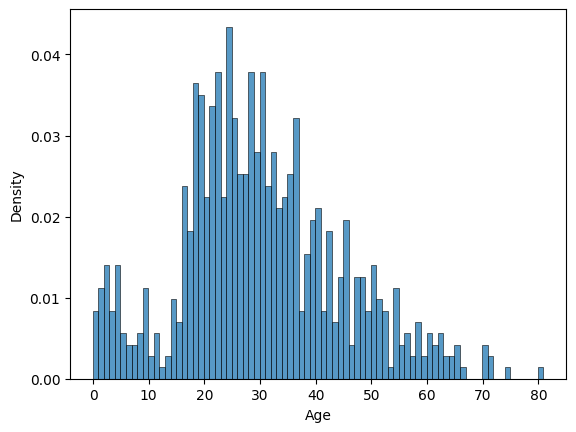

In [124]:
sns.histplot(df.Age, discrete=True, stat='density')

In [125]:
age_lst = np.unique(df[(df['Age'] > 18) & (df['Age'] < 38)  & ~(df.Age.isnull())].Age)

In [126]:
df.Age.isnull().sum()

177

In [127]:
ages = np.random.choice(age_lst, 177, replace=True)

In [128]:
idx_null_age = df[df.Age.isnull()].index

In [129]:
len(df.loc[idx_null_age, 'Age']) == len(ages)

True

In [130]:
df.loc[idx_null_age, 'Age'] = ages

so check dataset missing values for another once

In [132]:
df.Age.isnull().sum()

0

**Done for now**

---
**Note**: You can use another method to fill the missing values



## Add Features

In [133]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,F G73,S,Mr
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,F38,S,Miss
3,4,1,1,female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,male,35.0,0,0,373450,8.0500,F G73,S,Mr


**we can normalize the Tickets column but for we passed it like this**

Let's do the pairwise plot

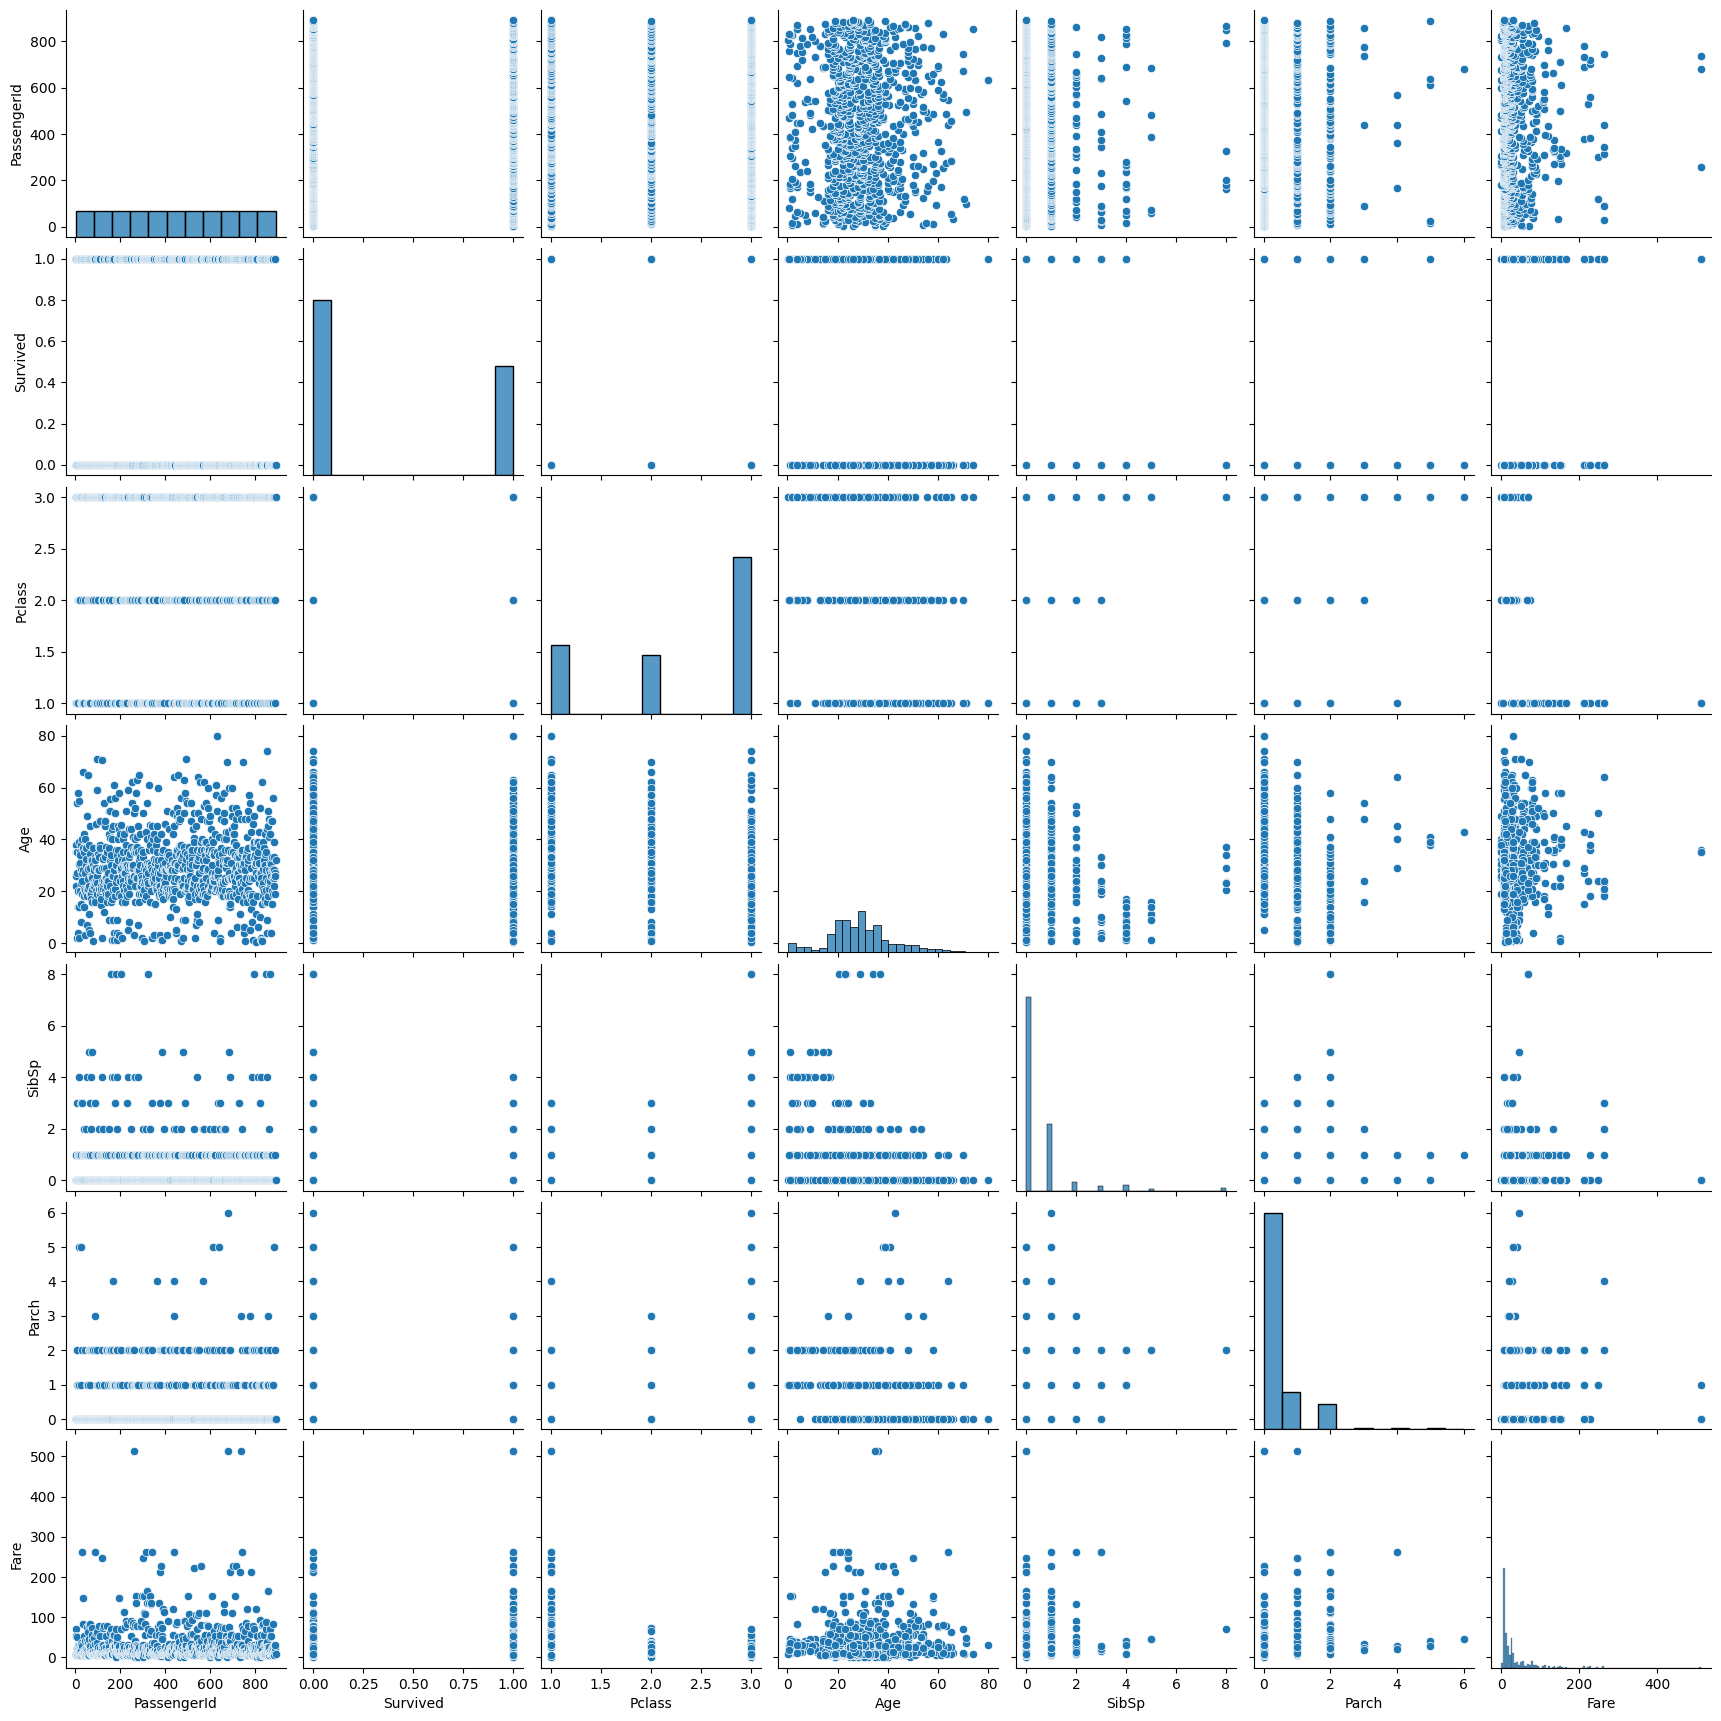

In [134]:
sns.pairplot(df)

Lets check pearson correlation.

<Axes: >

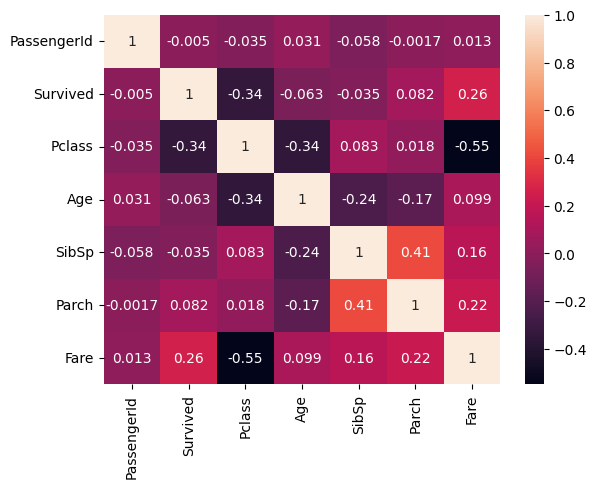

In [135]:
cm = df.corr(numeric_only=True)
sns.heatmap(cm, annot=True)

There were four main thing that we should pay attention:


1.   No `significatnt prearson correlation` with `Survived variable` greater or lower than 0.5, -0.5.
2.   we can see relation between variables `Fare` and `Pclass`, `Sibsp` , `Survived` in  pearson correlation and also confirm it with pairplot.
3.   in pariplot diagram in plot of `Age` and `Passenger id` we can see a blue line from up to down (age in x-axis), this is because we replace all `missing values` of `age` with mean, and if you see for further analysis we can select the number for missing values of `age` randomly from highly dense area of   `Age` and `Passenger id` plot
3.   **it seems there were `outliers` in dataset.**





Somthing else is that we should remove `passenger id` column or replace it as index of dataset because it contains unique value for each row.
I decided to remove it.
Remember: `index + 1 = passenger id`

In [136]:
df = df.drop(columns=['PassengerId'],axis=1)

In [137]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,0,3,male,22.0,1,0,A/5 21171,7.2500,F G73,S,Mr
1,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,F38,S,Miss
3,1,1,female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,0,3,male,35.0,0,0,373450,8.0500,F G73,S,Mr


In [138]:
df['Age_bin'] = pd.cut(df.Age, [0,10,20,30,50,70, df.Age.max()], labels=['child','young', 'adult', 'old', 'senile', 'disabled'], include_lowest=True)

In [139]:
df['is_alone'] = (df['Parch'] == 0) & (df['SibSp'] == 0)

In [140]:
df['family_size'] = df['Parch'] + df['SibSp'] + 1

In [141]:
np.unique(df['family_size'])

array([ 1,  2,  3,  4,  5,  6,  7,  8, 11])

In [142]:
np.unique(df['Parch'])

array([0, 1, 2, 3, 4, 5, 6])

In [143]:
df['freedom'] = pd.cut(df.family_size, [0,3, 5, 11], labels=['free', 'norm', 'crowded'], include_lowest=True)

In [144]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Age_bin,is_alone,family_size,freedom
0,0,3,male,22.0,1,0,A/5 21171,7.2500,F G73,S,Mr,adult,False,2,free
1,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,old,False,2,free
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,F38,S,Miss,adult,True,1,free
3,1,1,female,35.0,1,0,113803,53.1000,C123,S,Mrs,old,False,2,free
4,0,3,male,35.0,0,0,373450,8.0500,F G73,S,Mr,old,True,1,free


Encode Ticket for some analysis

In [145]:
from sklearn.preprocessing import LabelEncoder

In [146]:
encoding_t = LabelEncoder().fit_transform(df['Ticket'])
df['Ticket'] = encoding_t


<Axes: xlabel='Fare', ylabel='Ticket'>

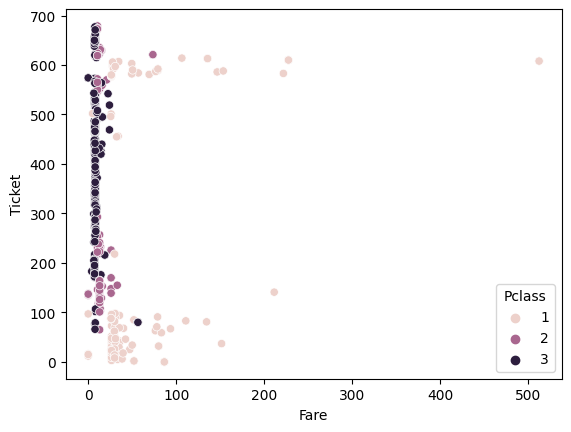

In [147]:
sns.scatterplot(data=df[(df['is_alone'])], x='Fare', y='Ticket', hue='Pclass')

<Axes: xlabel='Fare', ylabel='Ticket'>

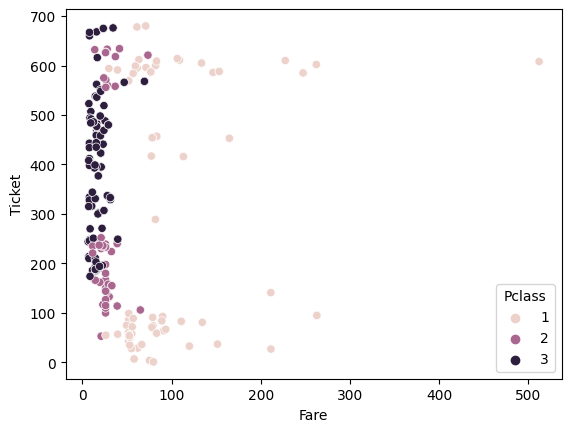

In [148]:
sns.scatterplot(data=df[~(df['is_alone'])], x='Fare', y='Ticket', hue='Pclass')

In [149]:
df['Fstat'] = pd.cut(df.Fare, [0,60,150,df.Fare.max()+1], labels=['normal','upnorm', 'rich'], include_lowest=True)

In [150]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Age_bin,is_alone,family_size,freedom,Fstat
0,0,3,male,22.0,1,0,523,7.2500,F G73,S,Mr,adult,False,2,free,normal
1,1,1,female,38.0,1,0,596,71.2833,C85,C,Mrs,old,False,2,free,upnorm
2,1,3,female,26.0,0,0,669,7.9250,F38,S,Miss,adult,True,1,free,normal
3,1,1,female,35.0,1,0,49,53.1000,C123,S,Mrs,old,False,2,free,normal
4,0,3,male,35.0,0,0,472,8.0500,F G73,S,Mr,old,True,1,free,normal


In [153]:
#preserve this dataset
df_origin = df.copy()

In [154]:
# Save semi-preprocessed__final dataset
# df.to_csv("/content/drive/MyDrive/Titanic/semi-preprocessed_final.csv", index=False)

In [155]:
# read semi-preprocessed__final dataset
# df = pd.read_csv("/content/drive/MyDrive/Titanic/semi-preprocessed_final.csv")

**Good Let's do some prepration for predictive analysis**

# Predictive Analysis

## Preprocessing

In [156]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Age_bin,is_alone,family_size,freedom,Fstat
0,0,3,male,22.0,1,0,523,7.2500,F G73,S,Mr,adult,False,2,free,normal
1,1,1,female,38.0,1,0,596,71.2833,C85,C,Mrs,old,False,2,free,upnorm
2,1,3,female,26.0,0,0,669,7.9250,F38,S,Miss,adult,True,1,free,normal
3,1,1,female,35.0,1,0,49,53.1000,C123,S,Mrs,old,False,2,free,normal
4,0,3,male,35.0,0,0,472,8.0500,F G73,S,Mr,old,True,1,free,normal


In [158]:
df.freedom.value_counts()

free       800
crowded     47
norm        44
Name: freedom, dtype: int64

Features Encoding  

---

We shoud recognize our ordinal and nominal features  

Ordinal: `age_bin`, `Fstat`, `freedom`  
Nominal: `Sex`, `Cabin`, `Embarked`, `Title`, `is_alone`

In [160]:
# for ordinal
from sklearn.preprocessing import LabelEncoder

# encoding_s = LabelEncoder().fit_transform(df['Sex'])
# df['Sex'] = encoding_s

# encoding_e = LabelEncoder().fit_transform(df['Embarked'])
# df['Embarked'] = encoding_e

# encoding_c = LabelEncoder().fit_transform(df['Cabin'])
# df['Cabin'] = encoding_c

# encoding_t = LabelEncoder().fit_transform(df['Ticket'])
# df['Ticket'] = encoding_t

# encoding_title = LabelEncoder().fit_transform(df['Title'])
# df['Title'] = encoding_title

encoding_ab = LabelEncoder().fit_transform(df['Age_bin'])
df['Age_bin'] = encoding_ab

encoding_ia = LabelEncoder().fit_transform(df['is_alone'])
df['is_alone'] = encoding_ia # it is treue or false in one columns

encoding_fs = LabelEncoder().fit_transform(df['Fstat'])
df['Fstat'] = encoding_fs

encoding_fr = LabelEncoder().fit_transform(df['freedom'])
df['freedom'] = encoding_fr


In [161]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Age_bin,is_alone,family_size,freedom,Fstat
0,0,3,male,22.0,1,0,523,7.2500,F G73,S,Mr,0,0,2,1,0
1,1,1,female,38.0,1,0,596,71.2833,C85,C,Mrs,3,0,2,1,2
2,1,3,female,26.0,0,0,669,7.9250,F38,S,Miss,0,1,1,1,0
3,1,1,female,35.0,1,0,49,53.1000,C123,S,Mrs,3,0,2,1,0
4,0,3,male,35.0,0,0,472,8.0500,F G73,S,Mr,3,1,1,1,0


Encoding for nominal

In [164]:
# pd.get_dummies(df, columns=['Sex', 'Cabin', 'Embarked', 'Title'])

In [165]:
#nominal features

df = pd.get_dummies(df, columns=['Sex', 'Cabin', 'Embarked', 'Title'])

Let's check we need to scaling the data or not.

In [166]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Age_bin,is_alone,family_size,...,Cabin_G6,Cabin_T,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Misc,Title_Miss,Title_Mr,Title_Mrs
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,...,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.323423,0.523008,0.381594,338.528620,32.204208,2.115600,0.602694,1.904602,...,0.076319,0.001122,0.188552,0.086420,0.725028,0.044893,0.030303,0.204265,0.580247,0.140292
std,0.486592,0.836071,13.266178,1.102743,0.806057,200.850657,49.693429,1.861826,0.489615,1.613459,...,0.265657,0.033501,0.391372,0.281141,0.446751,0.207186,0.171516,0.403390,0.493796,0.347485
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,21.000000,0.000000,0.000000,158.500000,7.910400,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,3.000000,28.000000,0.000000,0.000000,337.000000,14.454200,3.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,3.000000,36.000000,1.000000,0.000000,519.500000,31.000000,3.000000,1.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,680.000000,512.329200,5.000000,1.000000,11.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


yes we need if you look at the `mean` and `std` parameters based on `central tendency parameters` we need scaling for our algorithms

Let's Check balance of Target variable.

---



---


As you can see it is good balance, and we know that in binary classification if we want to predict badly it will be 50 50 like tossing the coin and here we have `62 percent chance` to predict `0` and `38 percent chance` to predict `1`, so we create an algorithm to predict it with much higher percent.

In [167]:
df['Survived'].value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

## Create Models

Lets split our set to `validation` and `train` set

In [168]:
from sklearn.model_selection import train_test_split

X = df.iloc[:, 1:]
y = df.iloc[:, 0]

In [169]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, test_size=0.3, random_state=0)

In [170]:
X_train.shape, X_valid.shape

((623, 168), (268, 168))

**Scaler Note**: we do not scale target variable.

In [171]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

X_valid = scaler.transform(X_valid)

### Logistic Regression

In [172]:
# model
from sklearn.linear_model import LogisticRegression
# tuning
from sklearn.model_selection import cross_validate, GridSearchCV
# metrics
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, classification_report, confusion_matrix


Lets create a simple model without tunning

In [173]:
logis = LogisticRegression()
logis.fit(X_train, y_train.values.ravel())

pred = logis.predict(X_valid)

print(classification_report(y_true=y_valid, y_pred=pred))

              precision    recall  f1-score   support

           0       0.81      0.92      0.86       165
           1       0.83      0.65      0.73       103

    accuracy                           0.81       268
   macro avg       0.82      0.78      0.79       268
weighted avg       0.82      0.81      0.81       268



Not too bad.
as we can see we have many `False Negative` and this is weakness of our logistic model and we should fight with it with `tuning` or `features engineering`.

<Axes: >

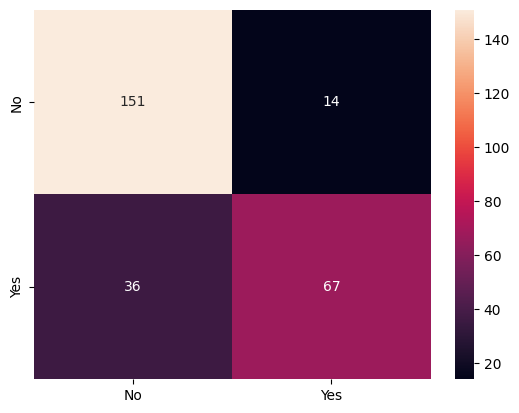

In [174]:
cm = confusion_matrix(y_true=y_valid, y_pred=pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['No','Yes'], yticklabels=['No','Yes'])

Let's do some hyperparameters tuning

In [175]:
logis = LogisticRegression(solver='liblinear', max_iter=1000)

params = {'C':[2*n for n in range(1,20)], 'penalty':['l1', 'l2']}

gr_logis = GridSearchCV(estimator=logis, param_grid=params, cv=3, n_jobs=-1)
gr_logis.fit(X_train, y_train.values.ravel())

gr_logis.best_params_, gr_logis.best_score_

({'C': 2, 'penalty': 'l1'}, 0.7897776539080886)

In [176]:
pred = gr_logis.predict(X_valid)

print(classification_report(y_true=y_valid, y_pred=pred))

              precision    recall  f1-score   support

           0       0.80      0.90      0.85       165
           1       0.80      0.64      0.71       103

    accuracy                           0.80       268
   macro avg       0.80      0.77      0.78       268
weighted avg       0.80      0.80      0.79       268



<Axes: >

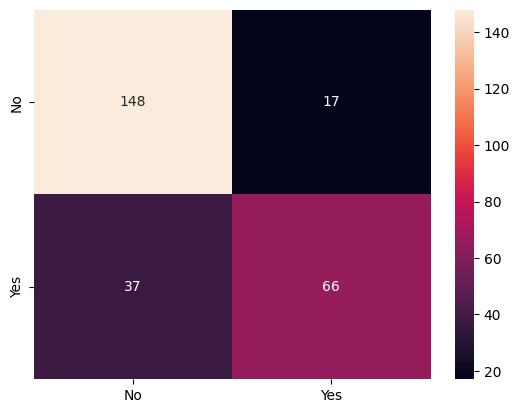

In [177]:
cm = confusion_matrix(y_true=y_valid, y_pred=pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['No','Yes'], yticklabels=['No','Yes'])

### SVC

In [178]:
from sklearn.svm import SVC

In [179]:
svc = SVC()

params = {'C':[0.2*n for n in range(1,20)], 'kernel':['linear', 'rbf', 'sigmoid', 'poly'], 'degree':[2,3,4]}

gr_svc = GridSearchCV(estimator=svc, param_grid=params, cv=3, n_jobs=-1)
gr_svc.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.2, 0.4, 0.6000000000000001, 0.8, 1.0,
                               1.2000000000000002, 1.4000000000000001, 1.6, 1.8,
                               2.0, 2.2, 2.4000000000000004, 2.6,
                               2.8000000000000003, 3.0, 3.2, 3.4000000000000004,
                               3.6, 3.8000000000000003],
                         'degree': [2, 3, 4],
                         'kernel': ['linear', 'rbf', 'sigmoid', 'poly']})

In [180]:
gr_svc.best_params_, gr_svc.best_score_

({'C': 1.6, 'degree': 2, 'kernel': 'sigmoid'}, 0.8234624674842066)

In [181]:
cs = cross_validate(X=X, y=y, estimator=gr_svc.best_estimator_, return_train_score=True, verbose=True, cv=3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished


In [182]:
cs

{'fit_time': array([0.04257417, 0.0354135 , 0.03420591]),
 'score_time': array([0.01590323, 0.01547551, 0.01800132]),
 'test_score': array([0.56565657, 0.53535354, 0.49158249]),
 'train_score': array([0.54377104, 0.53535354, 0.53367003])}

In [183]:
cs['test_score'].mean()

0.5308641975308642

In [184]:
pred = gr_svc.best_estimator_.predict(X_valid)

print(classification_report(y_valid, pred))

              precision    recall  f1-score   support

           0       0.83      0.88      0.85       165
           1       0.78      0.71      0.74       103

    accuracy                           0.81       268
   macro avg       0.81      0.79      0.80       268
weighted avg       0.81      0.81      0.81       268



<Axes: >

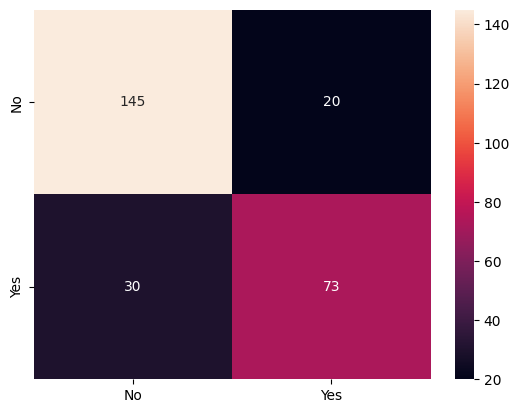

In [185]:
cm = confusion_matrix(y_true=y_valid, y_pred=pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['No','Yes'], yticklabels=['No','Yes'])

Little more better performance than Logistic Regression

### KNN

In [186]:
from sklearn.neighbors import KNeighborsClassifier

In [187]:
knn = KNeighborsClassifier()

params = {'n_neighbors':[2*(n+1) for n in range(20)], 'p':[1,2],
          'metric':['manhattan', 'nan_euclidean','l1','l2','euclidean','cityblock','cosine']}

gr_knn = GridSearchCV(knn, params, n_jobs=-1)

gr_knn.fit(X_train, y_train.values.ravel())



GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['manhattan', 'nan_euclidean', 'l1', 'l2',
                                    'euclidean', 'cityblock', 'cosine'],
                         'n_neighbors': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22,
                                         24, 26, 28, 30, 32, 34, 36, 38, 40],
                         'p': [1, 2]})

In [188]:
gr_knn.best_params_, gr_knn.best_score_

({'metric': 'manhattan', 'n_neighbors': 24, 'p': 1}, 0.7881032258064516)

In [189]:
pred = gr_knn.predict(X_valid)

print(classification_report(y_valid, pred))

              precision    recall  f1-score   support

           0       0.76      0.97      0.85       165
           1       0.91      0.50      0.65       103

    accuracy                           0.79       268
   macro avg       0.84      0.74      0.75       268
weighted avg       0.82      0.79      0.77       268



<Axes: >

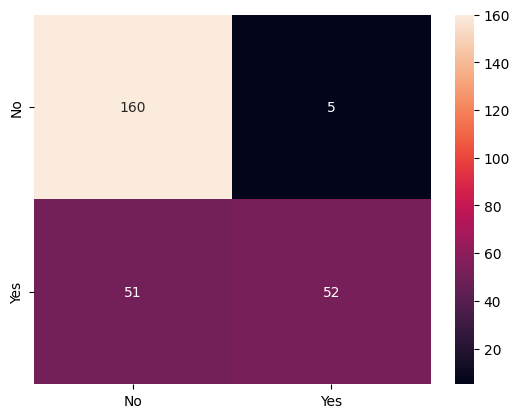

In [190]:
cm = confusion_matrix(y_true=y_valid, y_pred=pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['No','Yes'], yticklabels=['No','Yes'])

**Same like previous!!!**

### Boosting

#### RandomForest

In [191]:
from sklearn.ensemble import RandomForestClassifier

In [192]:
rf = RandomForestClassifier(bootstrap=True, warm_start=True)

params = {'n_estimators':[100,200,400], 'criterion':['gini'],
          'max_depth':[10,20,30], 'max_features':[None], 'min_samples_leaf':[1,2,3]}

gr_rf = GridSearchCV(rf, params, n_jobs=-1)

gr_rf.fit(X_train, y_train.values.ravel())

GridSearchCV(estimator=RandomForestClassifier(warm_start=True), n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [10, 20, 30],
                         'max_features': [None], 'min_samples_leaf': [1, 2, 3],
                         'n_estimators': [100, 200, 400]})

In [193]:
gr_rf.best_params_, gr_rf.best_score_

({'criterion': 'gini',
  'max_depth': 10,
  'max_features': None,
  'min_samples_leaf': 1,
  'n_estimators': 200},
 0.8347096774193549)

In [194]:
pred = gr_rf.predict(X_valid)

print(classification_report(y_valid, pred))

              precision    recall  f1-score   support

           0       0.81      0.93      0.87       165
           1       0.85      0.66      0.74       103

    accuracy                           0.82       268
   macro avg       0.83      0.79      0.81       268
weighted avg       0.83      0.82      0.82       268



<Axes: >

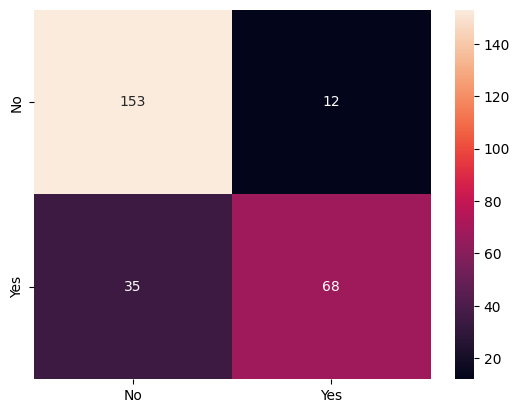

In [195]:
cm = confusion_matrix(y_true=y_valid, y_pred=pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['No','Yes'], yticklabels=['No','Yes'])

#### GBoost

In [196]:
from sklearn.ensemble import GradientBoostingClassifier

In [197]:
gb = GradientBoostingClassifier(loss='log_loss', warm_start=True)

params = {'n_estimators':[100,200,400],
          'max_depth':[10,20,30], 'min_samples_leaf':[1,2,3],
          'learning_rate':[0.1,1,2,4,10]}

gr_gb = GridSearchCV(gb, params, n_jobs=-1)

gr_gb.fit(X_train, y_train.values.ravel())

GridSearchCV(estimator=GradientBoostingClassifier(warm_start=True), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 1, 2, 4, 10],
                         'max_depth': [10, 20, 30],
                         'min_samples_leaf': [1, 2, 3],
                         'n_estimators': [100, 200, 400]})

In [198]:
gr_gb.best_params_, gr_gb.best_score_

({'learning_rate': 0.1,
  'max_depth': 30,
  'min_samples_leaf': 2,
  'n_estimators': 400},
 0.8331225806451613)

In [199]:
pred = gr_gb.predict(X_valid)

print(classification_report(y_valid, pred))

              precision    recall  f1-score   support

           0       0.80      0.90      0.85       165
           1       0.80      0.64      0.71       103

    accuracy                           0.80       268
   macro avg       0.80      0.77      0.78       268
weighted avg       0.80      0.80      0.80       268



<Axes: >

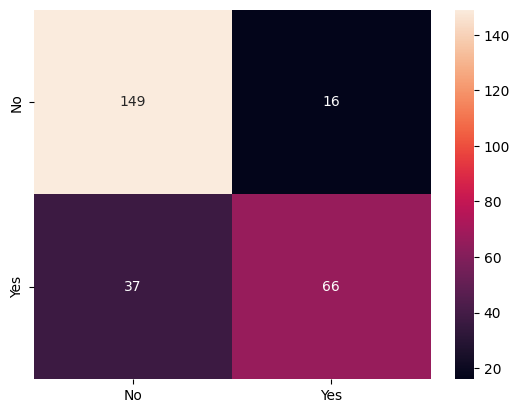

In [200]:
cm = confusion_matrix(y_true=y_valid, y_pred=pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['No','Yes'], yticklabels=['No','Yes'])

### Bagging

We want to use bagging classifier with `SVC` as base estimator

In [201]:
from sklearn.ensemble import BaggingClassifier

In [202]:
base_estm = gr_svc.best_estimator_

bc = BaggingClassifier(estimator=base_estm, bootstrap=True, warm_start=True)

params = {'n_estimators':[60,100,200,400]}

gr_bc = GridSearchCV(bc, params, n_jobs=-1)

gr_bc.fit(X_train, y_train.values.ravel())

GridSearchCV(estimator=BaggingClassifier(estimator=SVC(C=1.6, degree=2,
                                                       kernel='sigmoid'),
                                         warm_start=True),
             n_jobs=-1, param_grid={'n_estimators': [60, 100, 200, 400]})

In [203]:
gr_bc.best_params_, gr_bc.best_score_

({'n_estimators': 60}, 0.8234451612903226)

In [204]:
pred = gr_bc.predict(X_valid)

print(classification_report(y_valid, pred))

              precision    recall  f1-score   support

           0       0.83      0.88      0.85       165
           1       0.78      0.71      0.74       103

    accuracy                           0.81       268
   macro avg       0.81      0.79      0.80       268
weighted avg       0.81      0.81      0.81       268



<Axes: >

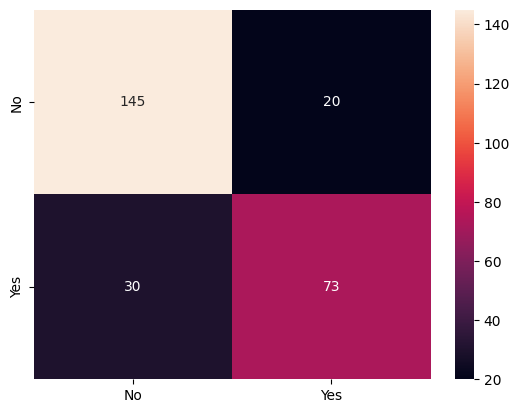

In [205]:
cm = confusion_matrix(y_true=y_valid, y_pred=pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['No','Yes'], yticklabels=['No','Yes'])

### Stacking

In [206]:
from sklearn.ensemble import StackingClassifier, VotingClassifier
# from sklearn.tree import DecisionTreeClassifier

We want to use Stacking classifier with `SVC`, `RandomForest` as base estimators and `SVC` for final estimator

In [207]:
estimators_list = [('SVC', gr_svc.best_estimator_), ('RF', gr_rf.best_estimator_)]

stk = StackingClassifier(estimators=estimators_list, final_estimator=SVC())

stk.fit(X_train, y_train.values.ravel())

StackingClassifier(estimators=[('SVC', SVC(C=1.6, degree=2, kernel='sigmoid')),
                               ('RF',
                                RandomForestClassifier(max_depth=10,
                                                       max_features=None,
                                                       n_estimators=200,
                                                       warm_start=True))],
                   final_estimator=SVC())

In [208]:
pred = stk.predict(X_valid)

print(classification_report(y_valid, pred))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86       165
           1       0.80      0.72      0.76       103

    accuracy                           0.82       268
   macro avg       0.82      0.80      0.81       268
weighted avg       0.82      0.82      0.82       268



<Axes: >

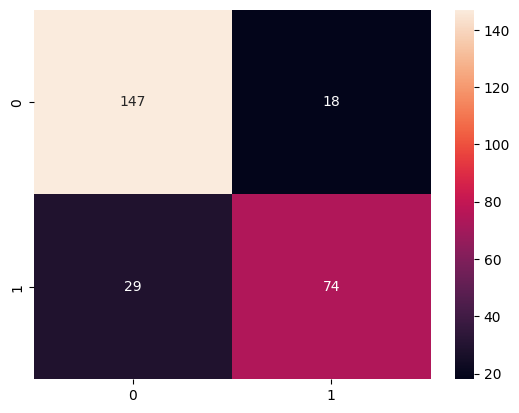

In [209]:
cm = confusion_matrix(y_true=y_valid, y_pred=pred)

sns.heatmap(cm, annot=True, fmt='d')

Now we want to use Voting classifier with `SVC`, `RandomForest` as base estimators and voting `hard` for final prediction.

In [210]:
estimators_list = [('SVC', gr_svc.best_estimator_), ('RF', gr_rf.best_estimator_)]

vt = VotingClassifier(estimators=estimators_list, voting='hard')

vt.fit(X_train, y_train.values.ravel())

VotingClassifier(estimators=[('SVC', SVC(C=1.6, degree=2, kernel='sigmoid')),
                             ('RF',
                              RandomForestClassifier(max_depth=10,
                                                     max_features=None,
                                                     n_estimators=200,
                                                     warm_start=True))])

In [211]:
pred = vt.predict(X_valid)

print(classification_report(y_valid, pred))

              precision    recall  f1-score   support

           0       0.80      0.96      0.87       165
           1       0.90      0.62      0.74       103

    accuracy                           0.83       268
   macro avg       0.85      0.79      0.80       268
weighted avg       0.84      0.83      0.82       268



<Axes: >

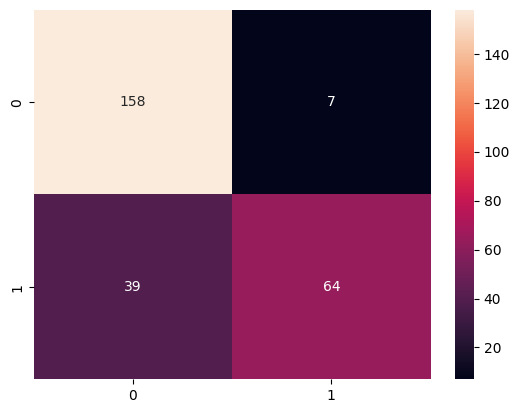

In [212]:
cm = confusion_matrix(y_true=y_valid, y_pred=pred)

sns.heatmap(cm, annot=True, fmt='d')

We create a few models with this dataset and now we want to perform somthing else.  
`PCA, KernelPCA and Clustering technique`

In [213]:
from sklearn.decomposition import PCA, KernelPCA

it is important to scale your dataset when dealing with method that use distance metrics

In [214]:
pca = PCA()
pca.fit(X_train)

PCA()

In [216]:
trans_pca = pca.transform(X_valid)

Lets visualize first two important components.

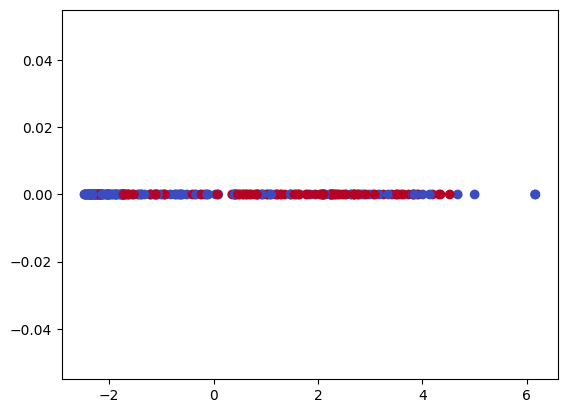

In [222]:
# projection onto component 1
plt.scatter(trans_pca[:, 0], np.zeros(trans_pca[:, 0].shape[0]), c=y_valid, cmap='coolwarm')

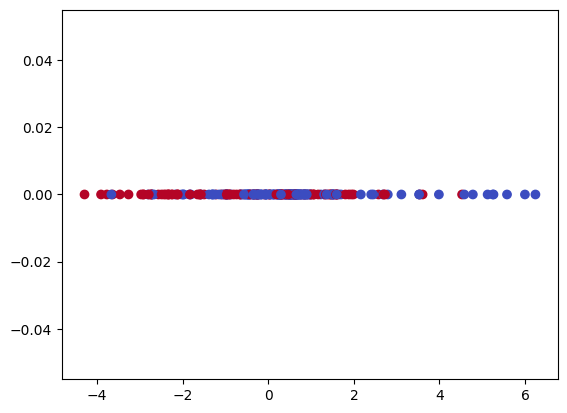

In [223]:
# projection onto component 2
plt.scatter(trans_pca[:, 1], np.zeros(trans_pca[:, 0].shape[0]), c=y_valid, cmap='coolwarm')

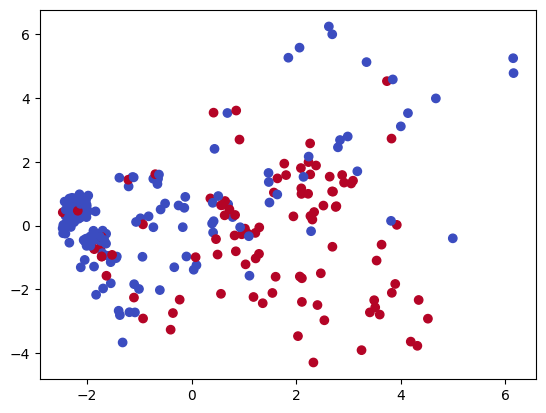

In [224]:
# projection onto component 1 and 2
plt.scatter(trans_pca[:, 0], trans_pca[:, 1], c=y_valid, cmap='coolwarm')

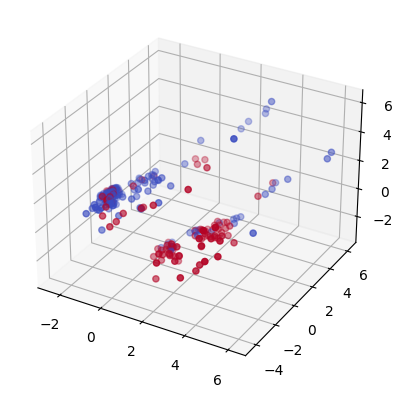

In [247]:
# projection onto component 1 and 2 and 3
ax = plt.subplot(projection='3d')
ax.scatter(trans_pca[:, 0], trans_pca[:, 1], trans_pca[:, 2], c=y_valid, cmap='coolwarm')

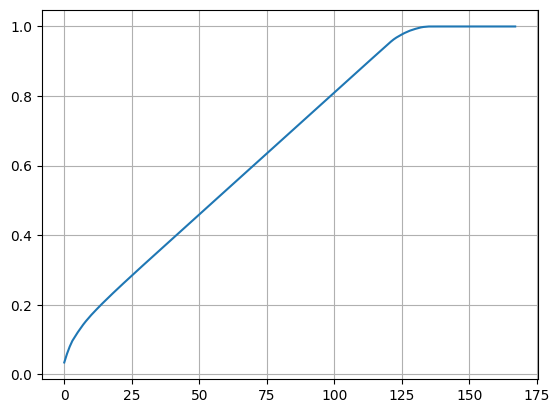

In [233]:
# Comulative sum
cumsum_pca = np.cumsum(pca.explained_variance_ratio_)

plt.plot(range(len(cumsum_pca)), cumsum_pca)
plt.grid(True)
plt.show()

In [234]:
X_valid.shape

(268, 168)

We can see from analysis that we can 125 or 130 from 168 features and still have most variance explanation.  
**Other features are redundant**

Kernel PCA

In [248]:
kpca = KernelPCA(kernel='rbf', gamma=10, fit_inverse_transform=True, alpha=0.1)
kpca.fit(X_train)

KernelPCA(alpha=0.1, fit_inverse_transform=True, gamma=10, kernel='rbf')

In [249]:
trans_kpca = kpca.transform(X_valid)

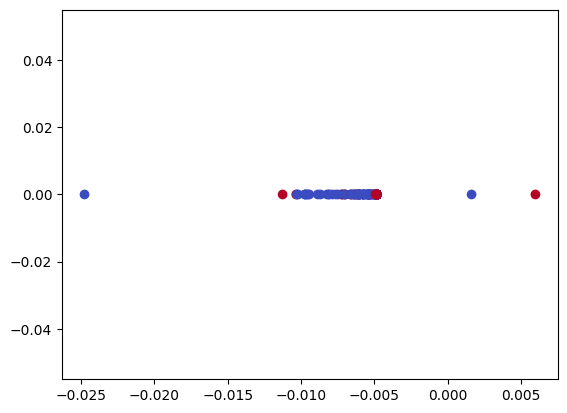

In [250]:
# projection onto component 1
plt.scatter(trans_kpca[:, 0], np.zeros(trans_kpca[:, 0].shape[0]), c=y_valid, cmap='coolwarm')

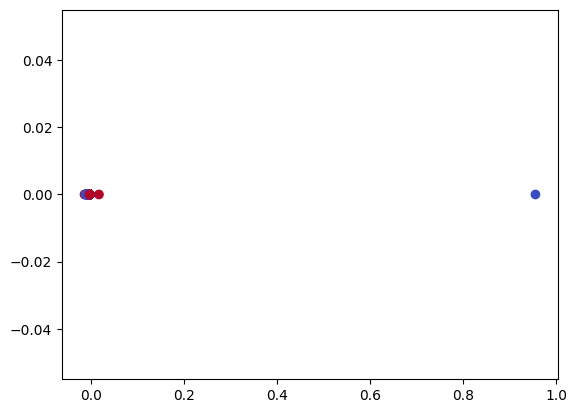

In [251]:
# projection onto component 2
plt.scatter(trans_kpca[:, 2], np.zeros(trans_kpca[:, 2].shape[0]), c=y_valid, cmap='coolwarm')

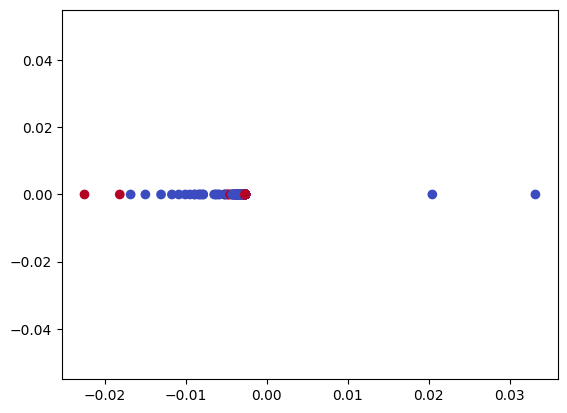

In [252]:
# projection onto component 3
plt.scatter(trans_kpca[:, 3], np.zeros(trans_kpca[:, 3].shape[0]), c=y_valid, cmap='coolwarm')

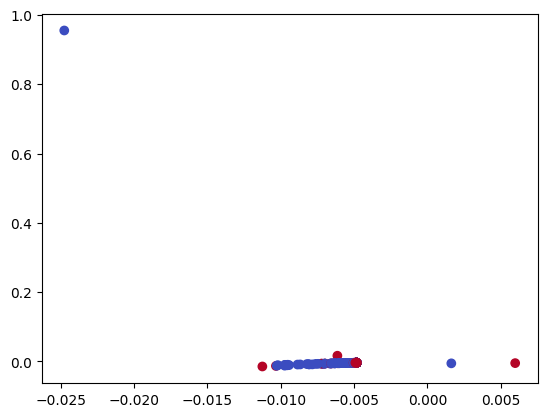

In [253]:
# projection onto component 1 and 2
plt.scatter(trans_kpca[:, 0], trans_kpca[:, 2], c=y_valid, cmap='coolwarm')

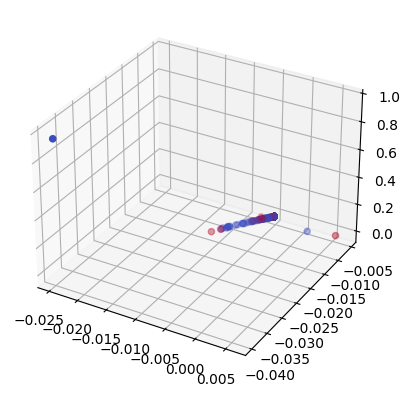

In [254]:
# projection onto component 1 and 2 and 3
ax = plt.subplot(projection='3d')
ax.scatter(trans_kpca[:, 0], trans_kpca[:, 1], trans_kpca[:, 2], c=y_valid, cmap='coolwarm')

There we can see some sort of differentiates in space of data points that can help us in predictive analysis.

## Models on new sets

Lets create best model from previous section on this new datasets

### Stacking

In [256]:
pca = PCA(0.90)
pca.fit(X_train)
trans_pcat = pca.transform(X_train)
trans_pcav = pca.transform(X_valid)

kpca = KernelPCA(n_components=400, kernel='rbf', gamma=10, fit_inverse_transform=True, alpha=0.1)
kpca.fit(X_train)
trans_kpcat = kpca.transform(X_train)
trans_kpcav = kpca.transform(X_valid)

In [257]:
stk.fit(trans_pcat, y_train)

StackingClassifier(estimators=[('SVC', SVC(C=1.6, degree=2, kernel='sigmoid')),
                               ('RF',
                                RandomForestClassifier(max_depth=10,
                                                       max_features=None,
                                                       n_estimators=200,
                                                       warm_start=True))],
                   final_estimator=SVC())

<Axes: >

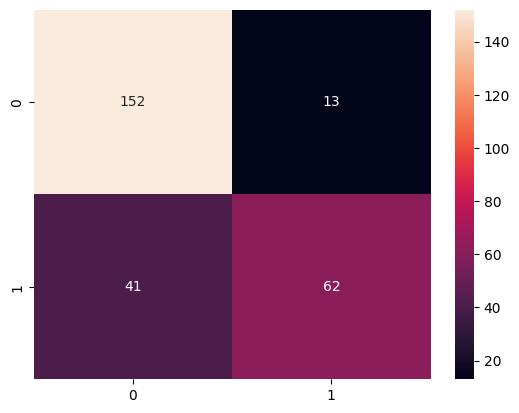

In [260]:
pred = stk.predict(trans_pcav)
cm = confusion_matrix(y_true=y_valid, y_pred=pred)
sns.heatmap(cm, annot=True, fmt='d')

Fit on KernelPCA transfrom set

In [ ]:
stk.fit(trans_kpcat, y_train)

<Axes: >

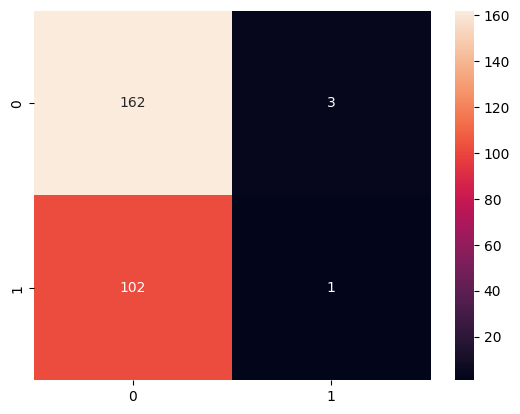

In [263]:
pred = stk.predict(trans_kpcav)
cm = confusion_matrix(y_true=y_valid, y_pred=pred)
sns.heatmap(cm, annot=True, fmt='d')

Worst performance on kernel PCA :(

### Randomforest

<Axes: >

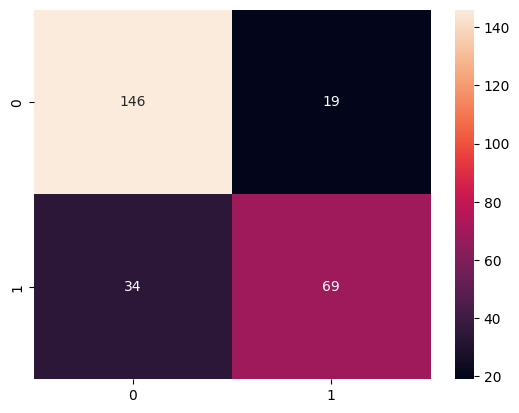

In [261]:
gr_rf.fit(trans_pcat, y_train)
pred = gr_rf.predict(trans_pcav)
cm = confusion_matrix(y_true=y_valid, y_pred=pred)
sns.heatmap(cm, annot=True, fmt='d')

Fit on KernelPCA transfrom set

# Conclusion for now :
as we saw, we created 5 models and approximately took same results for them, there are several things we can coclude from this process:

We use wide varitey of models from simplest to complex and we get approximately same results for all of them it is mean that `we should create some homemade algorithm to get better performance on *this dataset`.
Another thing is that we create some new features for our analysis and we use them to gain better prediction.
this dataset has many missing values and because of that we can not be sure if we fill missing valuse then we achived more useful info or we get more noise and false information.
Best prediction for `not survived` was `29` false negative and best prediction for `survived` was `5` false positive.
Another thing is we can use entire dataset as training set cause this competition from kaggle also publish a test set for it.



# next steps

1. we can use `RFECV` (Recursive Feature Elimination with Cross-Validation) performs recursive feature elimination with cross-validation loop to extract the optimal features for our predictive analysis.

2. We can analysis dataset for outliers and more about missing values.

3. We can remove more randomize features from data set like `cabin` and `name` and `title` and ...
4. More analyse on dimensionality reduction